<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q equinox==0.9.2  # ok on colab with jax 0.3.35 (just for last item of the nb)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.8 MB/s eta 0:00:00


In [2]:
import jax

import jax.numpy as jnp                       #<----------
import numpy as np                            #<----------

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18


# Theme: get some first flavour of JAX

One remark concerns the import: there is 2 ways of naming that you can see in libs:

-    either (numpy -> np, jax.numpy -> jnp)
-    or (numpy -> onp, jax.numpy -> np)

So, when you edit or C&P a JAX code have a look at import to figure out which convention has been adopted by the author(s).


# Automatic differentiation and vectorization

## Why auto-diff may be useful

In [3]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [4]:
# Exact f'(x) et f''(x)
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

# Numerical differenciation via central finite differences  f'(x) et f''(x)
def fpnum(x,h=0.1):
    return (f(x+h)-f(x-h))/(2*h)
def fppnum(x,h=0.1):
    return (f(x+h)-2*f(x)+f(x-h))/h**2

In [5]:
# With JAX gradient (gard)
jfp  = grad(f)            #f'
jfpp = grad(grad(f))      #f''

Have a look at the code: take a paper and a pencil and check that this code is correct :)

In [6]:
jax.make_jaxpr(f)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = mul d e
  in (f,) }

In [7]:
jax.make_jaxpr(jfp)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = cos a
    _:f64[] = mul d e
    g:f64[] = mul d 1.0
    h:f64[] = mul 1.0 e
    i:f64[] = mul g f
    j:f64[] = mul h d
    k:f64[] = mul j 0.5
    l:f64[] = neg k
    m:f64[] = add_any i l
  in (m,) }

vectorization `vmap` is for instance used when we call a function with an array. The result is not like numpy vectorize which is a for-loop.  

In [8]:
jfp  = vmap(grad(f))
jfpp = vmap(grad(grad(f)))

In [9]:
jax.make_jaxpr(jfp)(jnp.array([0.,1.]))   # notice we create an DeviceArray (JAX) from a list as numpy does

{ lambda ; a:f64[2]. let
    b:f64[2] = neg a
    c:f64[2] = mul b 0.5
    d:f64[2] = exp c
    e:f64[2] = sin a
    f:f64[2] = cos a
    _:f64[2] = mul d e
    g:f64[2] = mul d 1.0
    h:f64[2] = mul 1.0 e
    i:f64[2] = mul g f
    j:f64[2] = mul h d
    k:f64[2] = mul j 0.5
    l:f64[2] = neg k
    m:f64[2] = add_any i l
  in (m,) }

In [10]:
x=jnp.arange(0,10,0.1)   # as numpy equivalent 

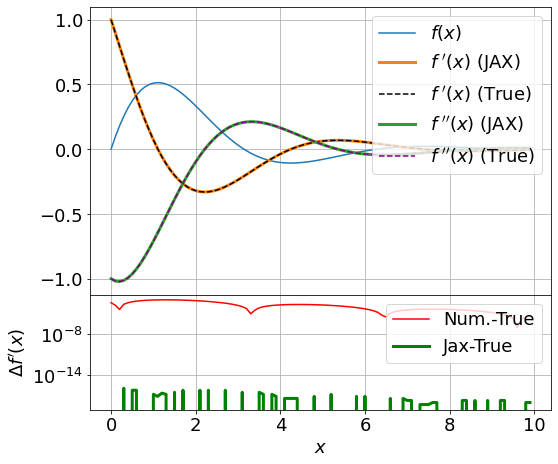

In [11]:
fig1 = plt.figure(1, figsize=(8,8))
frame1=fig1.add_axes((.1,.30,.8,.5))

plt.plot(x,f(x), label="$f(x)$")
#plt.scatter(x,fpnum(x), label="$f^{\ \prime}(x)$ (Num.)")
plt.plot(x,jfp(x), lw=3,label="$f^{\ \prime}(x)$ (JAX)")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$ (True)")
#plt.scatter(x,fppnum(x), label="$f^{\ \prime\prime}(x)$ (Num.)")
plt.plot(x,jfpp(x), lw=3,label="$f^{\ \prime\prime}(x)$ (JAX)")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$ (True)")
plt.grid()
plt.xlabel("$x$")
plt.legend(loc="upper right");

frame1.set_xticklabels([])
#frame1.set_xticks([])

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(x,np.abs(fpnum(x)-fp(x)), c="r", label="Num.-True")
plt.plot(x,np.abs(jfp(x)-fp(x)),lw=3,c="g",  label="Jax-True")
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\Delta f^{\prime}(x)$")
plt.yscale("log")
plt.legend(loc="upper right");

In [12]:
x=jnp.arange(0,10,0.1)
jnp.max(jnp.abs(jfpp(x)-fpp(x)))

DeviceArray(2.22044605e-16, dtype=float64)

As you see JAX auto-diff precision is at machine precision and finite differences may be difficult to tune (ie. h parameter) to get the same level of accuracy.



## Non-scalar function : jacobian
For non-scalar functions, the jacfwd or jacrev compute the Jacobian, as well as you can compute the hessian.

$$
f(W,x) = y = W x \quad \mathrm{with} \quad  W=\begin{pmatrix}
1 & 2 \\
3 & 5
\end{pmatrix}
$$

then we have two matrices per input $x=(x_1,x_2)$
$$
\begin{pmatrix}
\frac{\partial y_1}{\partial W_{11}}=x_1 & \frac{\partial y_1}{\partial W_{12}}= x_2\\
\frac{\partial y_1}{\partial W_{21}}=0 & \frac{\partial y_1}{\partial W_{12}}=0
\end{pmatrix}
$$
same kind of formula for $y_2$. 

In [13]:
def fvec(W,x):
  return W @ x


In [14]:
W = jnp.array([[1., 2.],[3.,5.]])
x = jnp.array([-1.,1.])

In [15]:
fvec(W,x)

DeviceArray([1., 2.], dtype=float64)

In [16]:
J =jacfwd(fvec)(W,x)
print(J.shape,"\n",J)

(2, 2, 2) 
 [[[-1.  1.]
  [ 0.  0.]]

 [[ 0.  0.]
  [-1.  1.]]]


## Auto-diff on multi-args function

The differentiation is by default on the 1st argument of the function but this is not exclusive


In [17]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.                 # function evaluated @ (3,4)
print(grad(func, argnums=0)(3., 4.))  # 8.      # df/dx    evaluated @  (3,4)
print(grad(func, argnums=1)(3., 4.))  # 6       # df/dy    evaluated @  (3,4)
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)  # both firs derivatives evaluated at once

8.0
8.0
6.0
(DeviceArray(8., dtype=float64, weak_type=True), DeviceArray(6., dtype=float64, weak_type=True))


# Example via the minimization of the Mean Squared Error (MSE)



## Model, loss

In [18]:
def model(p, x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return jnp.mean( (yhat - yi)**2 )

jnp.exp, jnp.sin ... are vectorized so  `model` and ``oss_fun` do not need vmap.

## Dataset
Let us now generate a dataset. Look at random number generation

In [19]:
# dataset
ptrue = jnp.array([0.5,1])

xin = jnp.arange(0,10,1.)
yerr = 0.05
# jax.random.PRNGKey(seed) simple way to give a key to the RNG
y_true =  model(ptrue, xin)
yin = y_true + yerr*jax.random.normal(jax.random.PRNGKey(42),shape=xin.shape)


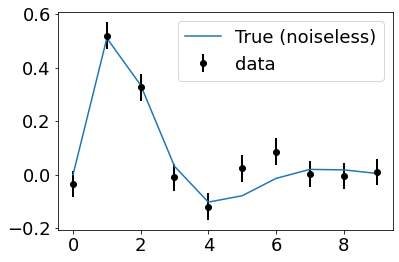

In [20]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data");
plt.plot(xin,y_true, label='True (noiseless)')
plt.legend();

notice: most of matplotlib accept JAX Device array asis as they have a numpy representation. If not use np.asarray(JAX-device-array)

## Gradient descent

In [21]:
@jit  # we will see what it is later
def gradient_descent_step(p, xi, yi, lr=0.1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)


Below is a simple minimizer from scratch with a for loop. We would use a more JAXy version later

In [22]:
def minimzer(loss_fun, x_data, y_data, par_init, method, verbose=True):
    p_cur = par_init
    new_loss=jnp.inf
    
    for t in range(5000):
   
        if (t % 100 == 0) and verbose:
            print(t, p_cur,new_loss)

        old_loss = new_loss
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)

        if jnp.abs(new_loss-old_loss) < 1e-9:
            print(f"Converged after {t} epochs: p = {new_p}, loss = {new_loss}")
            break

        p_cur = new_p

    return p_cur

In [23]:
par_mini_GD = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step, verbose=True)



0 [0.  0.5] inf
100 [0.62048393 0.70750834] 0.008637562559042187
200 [0.59232543 0.93250246] 0.003369178419368657
300 [0.54957041 1.04688945] 0.0017975857523135552
400 [0.53074669 1.08778781] 0.0015735323299857114
500 [0.52542832 1.09953584] 0.0015546792362664712
600 [0.52410865 1.10263342] 0.001553384289830772
Converged after 633 epochs: p = [0.52394625 1.10302972], loss = 0.0015533297417048115


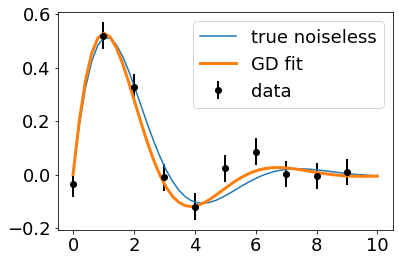

In [24]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.legend();


## Use 2nd order method : Hessian

In [25]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)


In [26]:
par_mini_Newton = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=oneStepNewton, verbose=True)

0 [0.  0.5] inf
100 [0.07535076 0.00358029] 0.039375743405272515
Converged after 183 epochs: p = [0.52373613 1.10348083], loss = 0.0015532978650187029


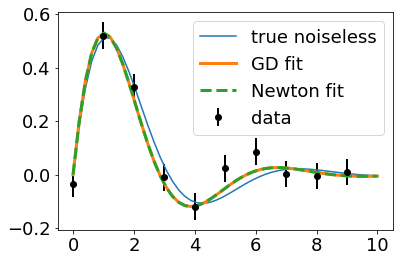

In [27]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.plot(x_val,model(par_mini_Newton, x_val),ls='--',lw=3,label="Newton fit")
plt.legend();


# Gradient/Vmap...wrt  tuples, lists, and dicts

In [28]:
def f(p:dict,x):
    return p["a"]**2 + p["b"]*x

$$
∂ f/\partial p(a) = 2 p(a), \qquad ∂ f/\partial p(b) = x 
$$

In [29]:
p= {"a":3.,"b":1.}
x = 10.
print(grad(f)(p,x))

{'a': DeviceArray(6., dtype=float64, weak_type=True), 'b': DeviceArray(10., dtype=float64, weak_type=True)}


$$\partial f / \partial x = p(b)$$

In [30]:
print(grad(f, argnums=1)(p,x))   

1.0


In [31]:
def f(p:tuple,x):
    return p[0]**2 + p[1]*x

In [32]:
p= (3.,1.)
x = 10.
print(grad(f)(p,x))

(DeviceArray(6., dtype=float64, weak_type=True), DeviceArray(10., dtype=float64, weak_type=True))


In [33]:
def f(p:list,x):
    return p[0]**2 + p[1]*x

In [34]:
p= [3.,1.]
x = 10.
print(grad(f)(p,x))

[DeviceArray(6., dtype=float64, weak_type=True), DeviceArray(10., dtype=float64, weak_type=True)]


# Vectorization partielle: in-axes

In [35]:
def f(p:dict,x):
    return p["a"]**2 + p["b"]*x

In [36]:
# We vectorize on the "b" values of the dictionnary as array of (1,2,3)
# p(a)=1, x=10
print(vmap(f, in_axes=({"a": None, "b": 0},None))({"a":1.,"b":jnp.array([1.,2.,3.])},10.))

[11. 21. 31.]


In [37]:
# make p(b)=2, x=10 and vectorize upon p(a)
vmap(f, in_axes=({"a":0, "b": None},None))({"a":jnp.array([1.,2.,3.]),"b":2.0},10)

DeviceArray([21., 24., 29.], dtype=float64)

A bit more in_axis manipulations

In [38]:
def func(a,b,x):
    return a**2 + b*x


In [39]:
vfunc = vmap(func, in_axes=(0,None,None))  # vectorize on "a"

In [40]:
vfunc(jnp.array([1.,2.,3.]), 1.,10.)

DeviceArray([11., 14., 19.], dtype=float64)

In [41]:
# map over 2 axis : "a" and "b"
vvfunc = vmap(vmap(func, in_axes=(0,None,None)),in_axes=(None,0,None))

In [42]:
vvfunc(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.,5.]),10.)
# x= 10
# a:(1,2,3) b: 0
# a:(1,2,3) b: 1
# a:(1,2,3) b: 4
# a:(1,2,3) b: 5


DeviceArray([[ 1.,  4.,  9.],
             [11., 14., 19.],
             [41., 44., 49.],
             [51., 54., 59.]], dtype=float64)

In [43]:
# Python list comprehension equiv.
[[func(ai,bj,x=10.) for ai in [1,2,3]] for bj in [0.,1.,4.,5.]]

[[1.0, 4.0, 9.0], [11.0, 14.0, 19.0], [41.0, 44.0, 49.0], [51.0, 54.0, 59.0]]

In [44]:
vmap(func,in_axes=(0,0,None))(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.]),10.)
# here map a,b at the same times : requires than arrays have the same sizes
#x=10
# a:1 b:0
# a:2 b:1
# a:3 b:4


DeviceArray([ 1., 14., 49.], dtype=float64)

In [45]:
# Python list comprehension equiv.
[func(ai,bj,x=10.) for ai,bj in zip([1,2,3],[0.,1.,4.,5.])]

[1.0, 14.0, 49.0]

Now, "0" in the above in_axes means the first dimension of each "a" and "b" args. 

What about if "b" is a matrix, and "a" a vector 

In [46]:
a = np.array([1.,2.,3.])
b = np.array([[0.,1.,4.],
               [1.,2.,8.]])

In [47]:
for i in range(len(a)):
  print(func(a[i],b[:,i],10))

[ 1. 11.]
[14. 24.]
[49. 89.]


In [48]:
# here is the vmap equivalent
vmap(func,in_axes=(0,1,None))(a,b,10.)

DeviceArray([[ 1., 11.],
             [14., 24.],
             [49., 89.]], dtype=float64)

# PyTree: a user structure adapted to JAX (vmap,grad,jit)

Here a simple example with a class with 2 fields (a, b).

Notice that one can implement in different way (eg. NamedTuple) and may use library (eg. Equinox)

In [49]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class Params:
    def __init__(self, a, b):
        self._a = a
        self._b = b

    def __repr__(self):
        return f"Params(a={self._a}, b={self._b})"

    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b

    def tree_flatten(self):
        children = (self._a, self._b)
        aux_data = None
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [50]:
my_params = Params(3.,1.)
my_params

Params(a=3.0, b=1.0)

In [51]:
def g(p: Params,x):
    return (p.a)**2 + (p.b)*x


In [52]:
print(grad(g)(my_params,10)) # as easy as arrays, dicts, lists

Params(a=6.0, b=10.0)


In [53]:
# vmaping to the "b" parameter (2nd field) of Params class
print(vmap(g, in_axes=(Params(None, 0), None))(Params(3., jnp.array([1.,2.,3.])), 10))

[19. 29. 39.]


In [54]:
# A way to see the structure
from jax.tree_util import tree_flatten, tree_unflatten
def show_example(structured):
    flat, tree = tree_flatten(structured)
    unflattened = tree_unflatten(tree, flat)
    print("structured={}\n  flat={}\n  tree={}\n  unflattened={}".format(
          structured, flat, tree, unflattened))

In [55]:
show_example(my_params)

structured=Params(a=3.0, b=1.0)
  flat=[3.0, 1.0]
  tree=PyTreeDef(CustomNode(Params[None], [*, *]))
  unflattened=Params(a=3.0, b=1.0)


# Use of Equinox data structure

In [56]:
! pip install -q equinox

In [58]:
import equinox as eqx  

#like a layer in a NN
class Model(eqx.Module):
  a : float                 # the params
  b : float

  def __init__(self, a,b):  # the init
    self.a = a
    self.b = b

  def __call__(self, x):    # the forward call
    return self.a + x *  self.b**2

In [63]:
def f(model, x):
  return vmap(model)(x)   # in the presnt use case vmap is not necessary

model = Model(a=0.,b=1.)

In [64]:
f(model,jnp.linspace(0.,10.,10))

DeviceArray([ 0.        ,  1.11111111,  2.22222222,  3.33333333,
              4.44444444,  5.55555556,  6.66666667,  7.77777778,
              8.88888889, 10.        ], dtype=float64)

In [67]:
grads = jacfwd(f)(model,jnp.linspace(0.,10.,10))

In [66]:
grads.a, grads.b

(DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64),
 DeviceArray([ 0.        ,  2.22222222,  4.44444444,  6.66666667,
               8.88888889, 11.11111111, 13.33333333, 15.55555556,
              17.77777778, 20.        ], dtype=float64))

# Takeaway message

- JAX rather easy to be on board in you know Python. After sometimes you will discover that you need to think differently (ie. pure-functions)
- jax.numpy as API close to Numpy. Now, DeviceArray are immutable objects so there are some adaptation
- auto-diff is easy and exact
- vmap is really amazing, there are other kinds of paralellization (eg. pmap for multi-devices)
- You can use JAX optimization on jnp.array, dict and User structures using PyTree 

Other nbs use JAX fucntions to use JIT (Just-In-Time compilation)

# Docs

- JAX https://jax.readthedocs.io/en/latest/index.html
